# Vanilla GP Supervised Learning on 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.models.vanilla_gp import VanillaGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

## Dataset Preprocessing

### Load & Settings

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

num_train = 10
num_test = 1000
normalize_features = False
normalize_labels = True

### Trainset & Testset

In [3]:
torch.manual_seed(1337)
rand_idx = torch.randperm(m)
train_idx = rand_idx[:num_train]
train_x, train_y = sampled_x[train_idx, :], sampled_y[train_idx]

noise_train_x = 0.05
train_x += noise_train_x * torch.randn(num_train, n)
noise_train_y = 0.05
train_y += noise_train_y * torch.randn(num_train)

test_idx = rand_idx[num_train:num_train+num_test]
test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

noise_test_x = 0.0
test_x += noise_test_x * torch.randn(num_test, n)
noise_test_y = 0.0
test_y += noise_test_y * torch.randn(num_test)

if normalize_features:
    mu_x, std_x = train_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    sampled_x.sub_(mu_x).div_(std_x)
    train_x.sub_(mu_x).div_(std_x)
    test_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)
    test_y.sub_(mu_y).div_(std_y)
    sampled_y.sub_(mu_y).div_(std_y)

### Move Data to Device

In [4]:
sampled_x, sampled_y = sampled_x.contiguous(), sampled_y.contiguous()
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
sampled_x, sampled_y = sampled_x.to(device), sampled_y.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

if normalize_features:
    mu_x, std_x = mu_x.to(device), std_x.to(device)

## Model

In [41]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
# gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

model = VanillaGP(train_x, train_y, likelihood, kernel).to(device)

hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.lengthscale': 2.5,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

## Train

In [6]:
model.vanilla_train(lr=1e-1, iter=200, verbose=True)

Iteration: 0, Loss: 1.273, Noise Variance: 0.100, Signal Variance: 1.000, Lengthscale: 0.500
Iteration: 1, Loss: 1.201, Noise Variance: 0.105, Signal Variance: 1.032, Lengthscale: 0.462
Iteration: 2, Loss: 1.158, Noise Variance: 0.110, Signal Variance: 1.062, Lengthscale: 0.427
Iteration: 3, Loss: 1.137, Noise Variance: 0.114, Signal Variance: 1.090, Lengthscale: 0.396
Iteration: 4, Loss: 1.129, Noise Variance: 0.118, Signal Variance: 1.114, Lengthscale: 0.369
Iteration: 5, Loss: 1.129, Noise Variance: 0.121, Signal Variance: 1.133, Lengthscale: 0.347
Iteration: 6, Loss: 1.133, Noise Variance: 0.122, Signal Variance: 1.145, Lengthscale: 0.329
Iteration: 7, Loss: 1.138, Noise Variance: 0.123, Signal Variance: 1.153, Lengthscale: 0.314
Iteration: 8, Loss: 1.142, Noise Variance: 0.124, Signal Variance: 1.155, Lengthscale: 0.303
Iteration: 9, Loss: 1.145, Noise Variance: 0.123, Signal Variance: 1.152, Lengthscale: 0.295
Iteration: 10, Loss: 1.145, Noise Variance: 0.122, Signal Variance: 1.

Iteration: 116, Loss: 1.110, Noise Variance: 0.031, Signal Variance: 0.994, Lengthscale: 0.305
Iteration: 117, Loss: 1.110, Noise Variance: 0.031, Signal Variance: 0.994, Lengthscale: 0.305
Iteration: 118, Loss: 1.110, Noise Variance: 0.030, Signal Variance: 0.994, Lengthscale: 0.304
Iteration: 119, Loss: 1.110, Noise Variance: 0.030, Signal Variance: 0.994, Lengthscale: 0.304
Iteration: 120, Loss: 1.110, Noise Variance: 0.030, Signal Variance: 0.994, Lengthscale: 0.305
Iteration: 121, Loss: 1.110, Noise Variance: 0.030, Signal Variance: 0.994, Lengthscale: 0.305
Iteration: 122, Loss: 1.110, Noise Variance: 0.030, Signal Variance: 0.994, Lengthscale: 0.305
Iteration: 123, Loss: 1.110, Noise Variance: 0.030, Signal Variance: 0.993, Lengthscale: 0.305
Iteration: 124, Loss: 1.110, Noise Variance: 0.029, Signal Variance: 0.993, Lengthscale: 0.305
Iteration: 125, Loss: 1.110, Noise Variance: 0.029, Signal Variance: 0.993, Lengthscale: 0.305
Iteration: 126, Loss: 1.110, Noise Variance: 0.029

## Evaluation

In [7]:
%%capture
likelihood.eval()
model.eval()

## Metrics

In [8]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(10000):
    preds_test = likelihood(model(test_x))
        
    error = test_y - preds_test.mean
    covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    
    rmse = (error.square().sum()/num_test).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/num_test
    
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(1.0491, device='cuda:0')
NLL:  tensor(-1.6337, device='cuda:0')


## Plot

In [9]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_manifold = model(sampled_x)
    
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-1.5, 1.5, resolution), torch.linspace(-1.5, 1.5, resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        preds_ambient = model(grid_x.sub(mu_x).div(std_x))
        sampled_x.mul_(std_x).add_(mu_x)
        train_x.mul_(std_x).add_(mu_x)
        test_x.mul_(std_x).add_(mu_x)
    else:
        preds_ambient = model(grid_x)

### Ground Truth

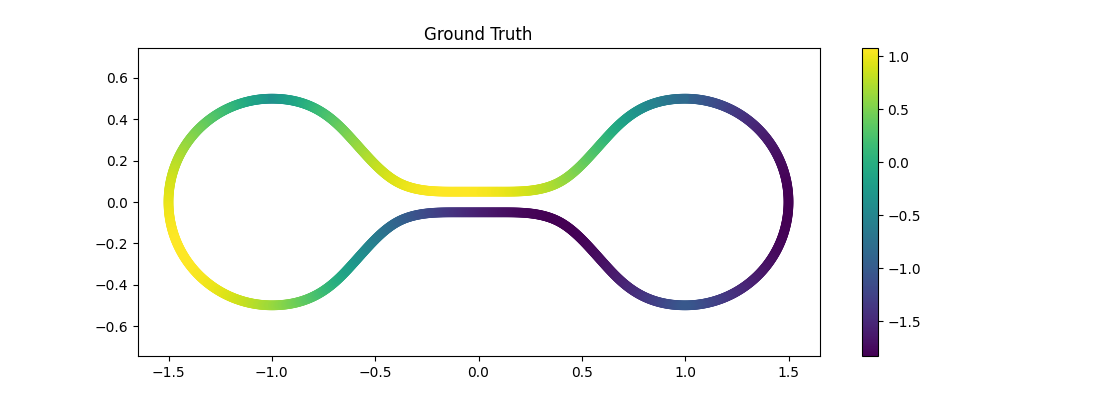

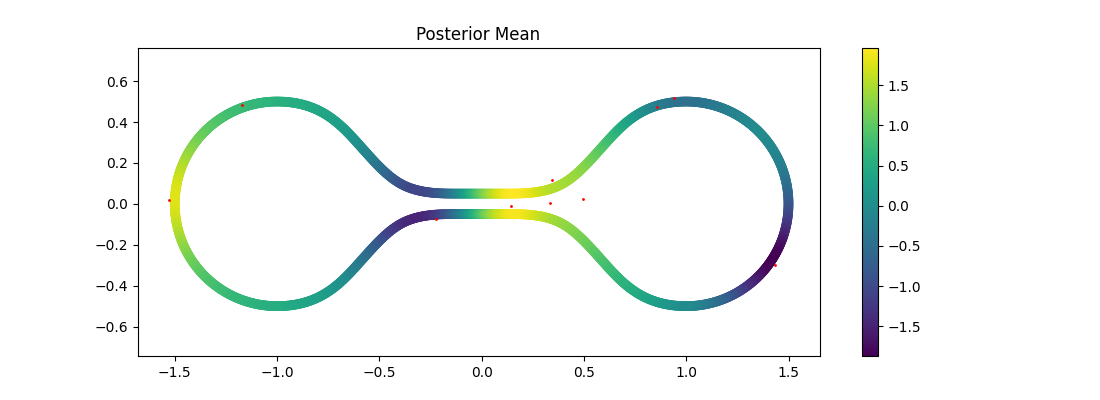

In [10]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=sampled_y.cpu().numpy())  # vmin=-0.5, vmax=0.5
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Ground Truth')
    
    if normalize_labels:
        posterior_mean_manifold = preds_manifold.mean.mul(std_y).add(mu_y).cpu().numpy()
    else:
        posterior_mean_manifold = preds_manifold.mean.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=posterior_mean_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=1.0)
#     ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='k', s=1.0)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

### Posterior Mean

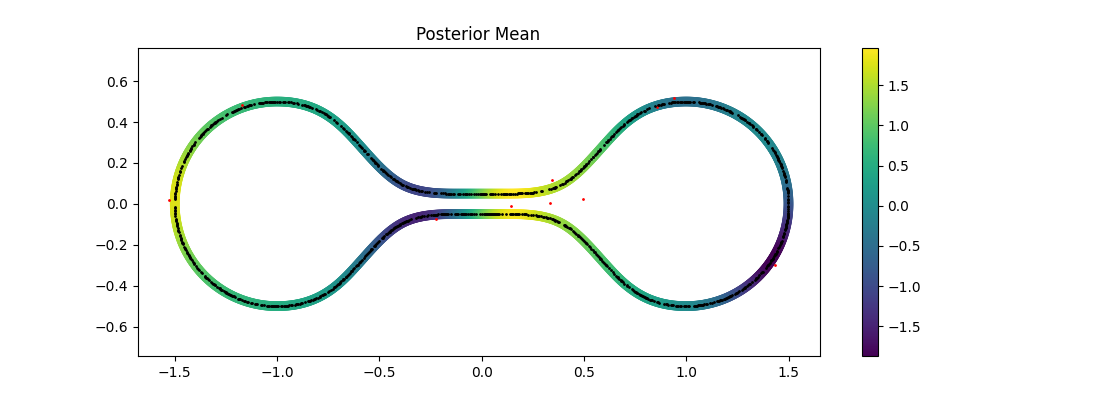

In [11]:
with torch.no_grad():
    if normalize_labels:
        posterior_mean_manifold = preds_manifold.mean.mul(std_y).add(mu_y).cpu().numpy()
    else:
        posterior_mean_manifold = preds_manifold.mean.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=posterior_mean_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=1.0)
    ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='k', s=1.0)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

### Kernel Evaluation

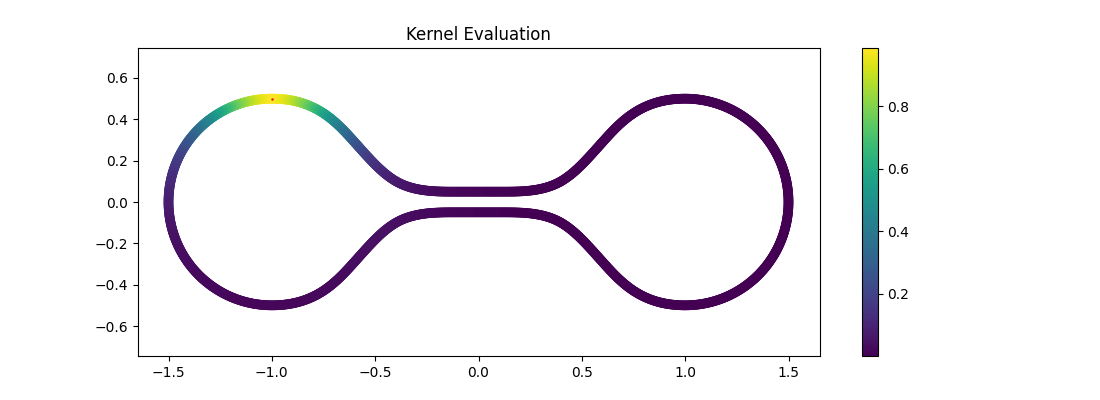

In [12]:
with torch.no_grad():
    kernel_eval_manifold = model.covar_module(sampled_x[0, :].unsqueeze(0), sampled_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=kernel_eval_manifold)
    ax.scatter(sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Prior Variance

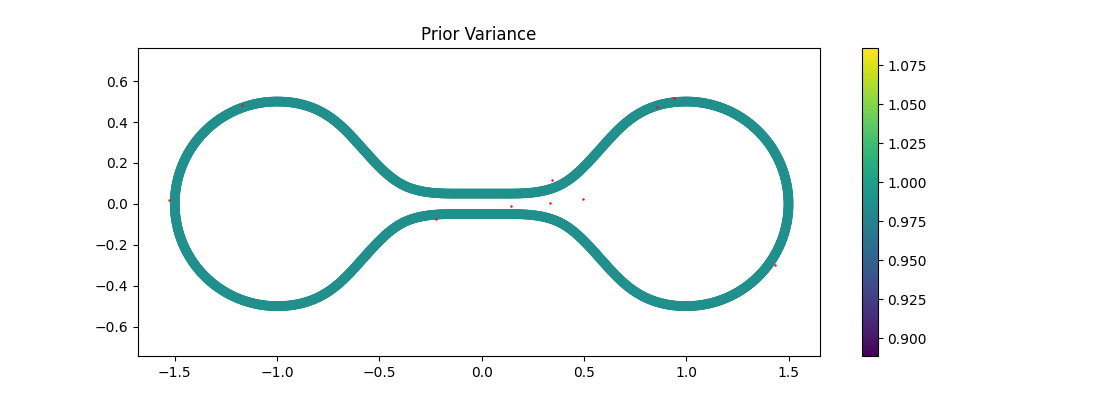

In [13]:
with torch.no_grad():
    prior_var_manifold = model.covar_module(sampled_x, sampled_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=prior_var_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Variance')

### Posterior Standard Deviation

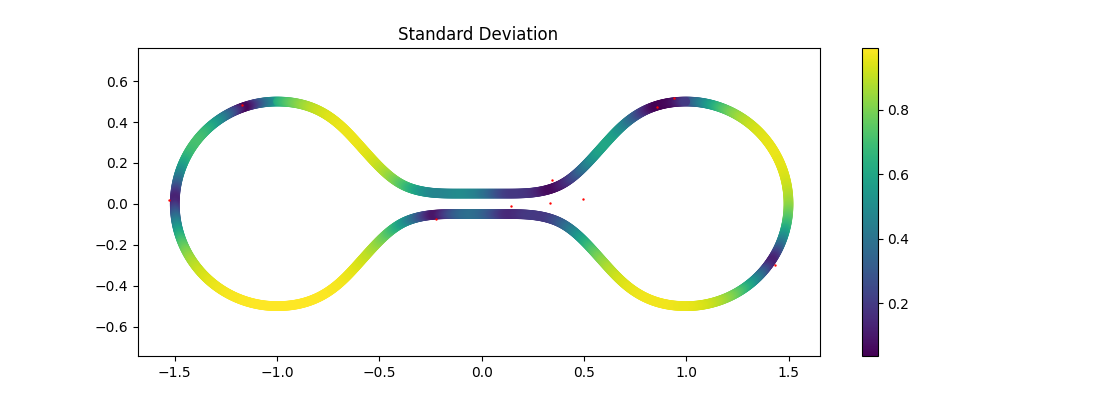

In [14]:
with torch.no_grad():
    posterior_std_manifold = preds_manifold.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=posterior_std_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

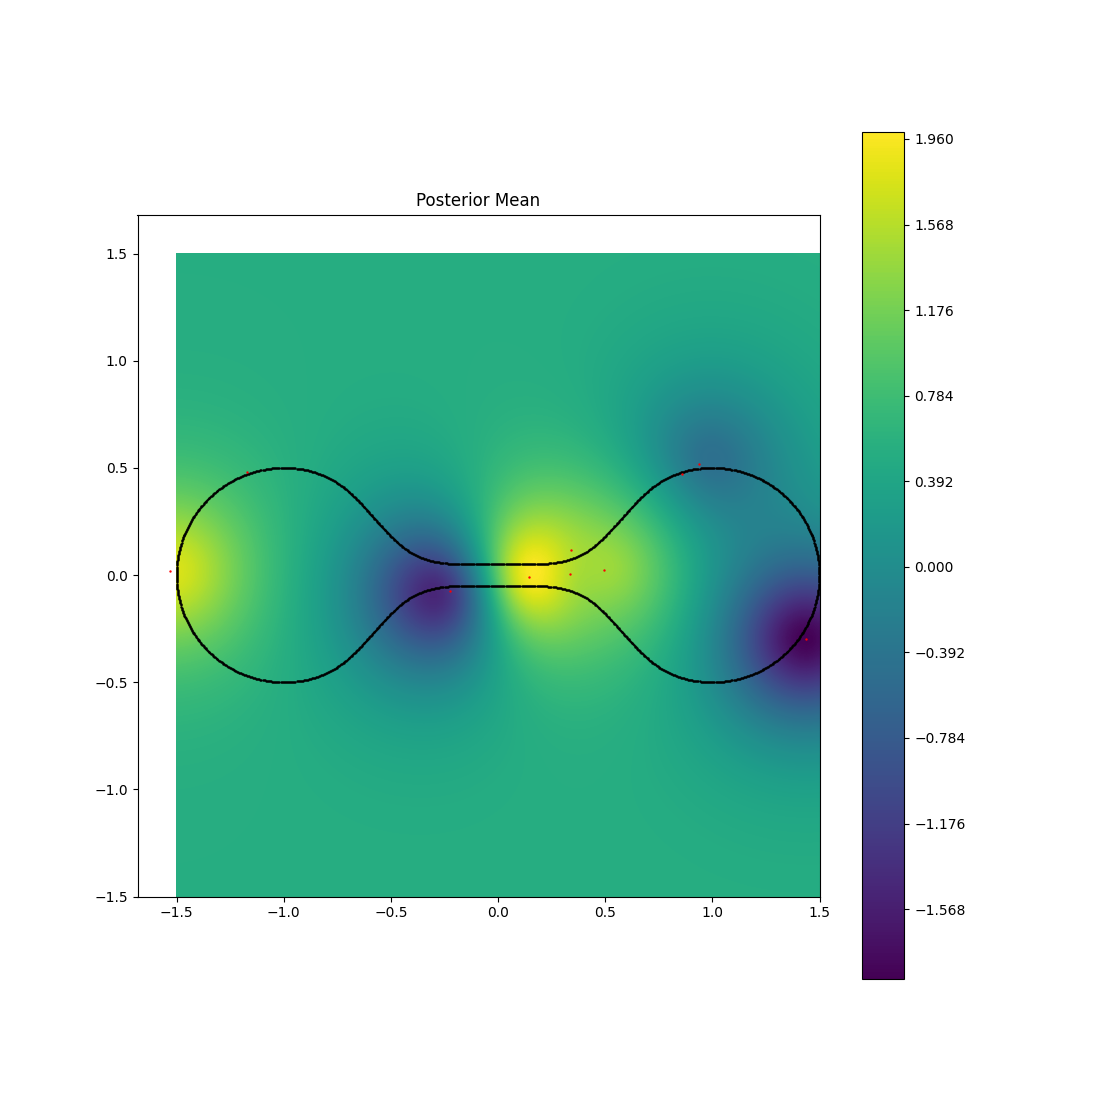

In [15]:
with torch.no_grad():
    if normalize_labels:
        posterior_mean_ambient = preds_ambient.mean.mul(std_y).add(mu_y).cpu().numpy()
    else:
        posterior_mean_ambient = preds_ambient.mean.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_mean_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

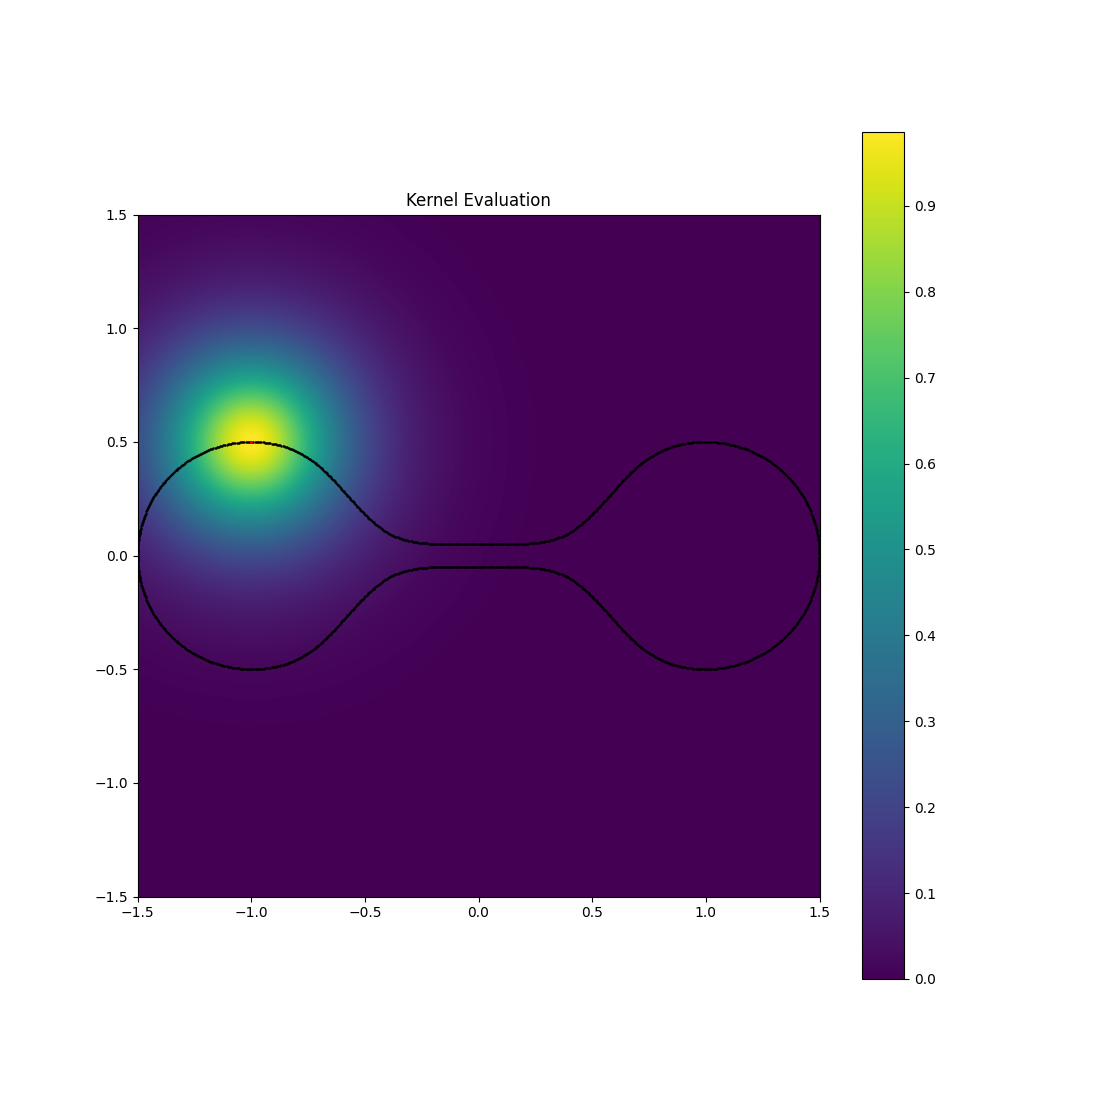

In [16]:
with torch.no_grad():
    kernel_eval_ambient = model.covar_module(sampled_x[0, :].unsqueeze(0), grid_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), kernel_eval_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1], c='r', s=1.0)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Kernel Evaluation')

### Ambient Prior Variance

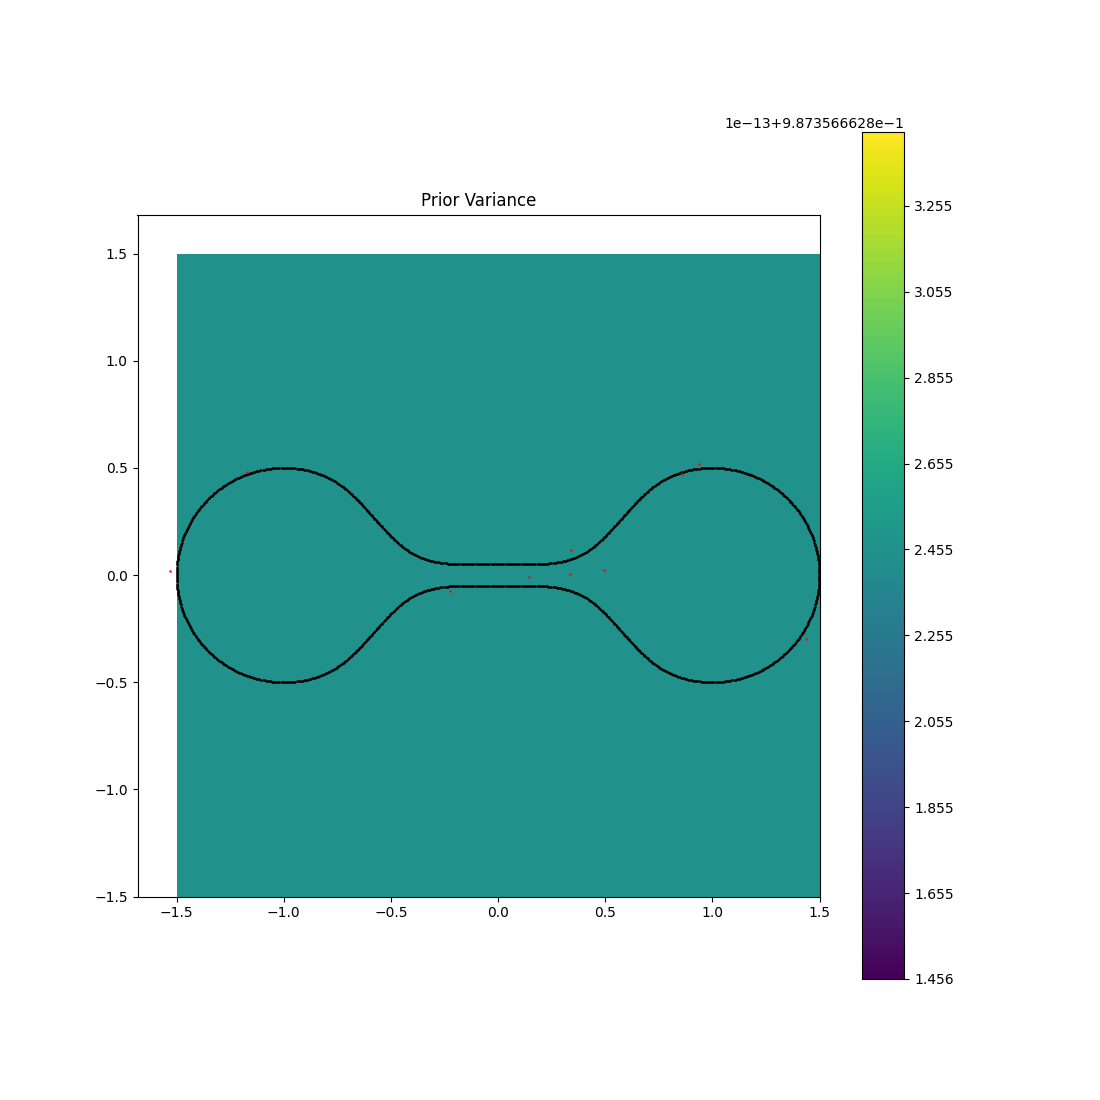

In [17]:
with torch.no_grad():
    prior_var_ambient = model.covar_module(grid_x, grid_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_var_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

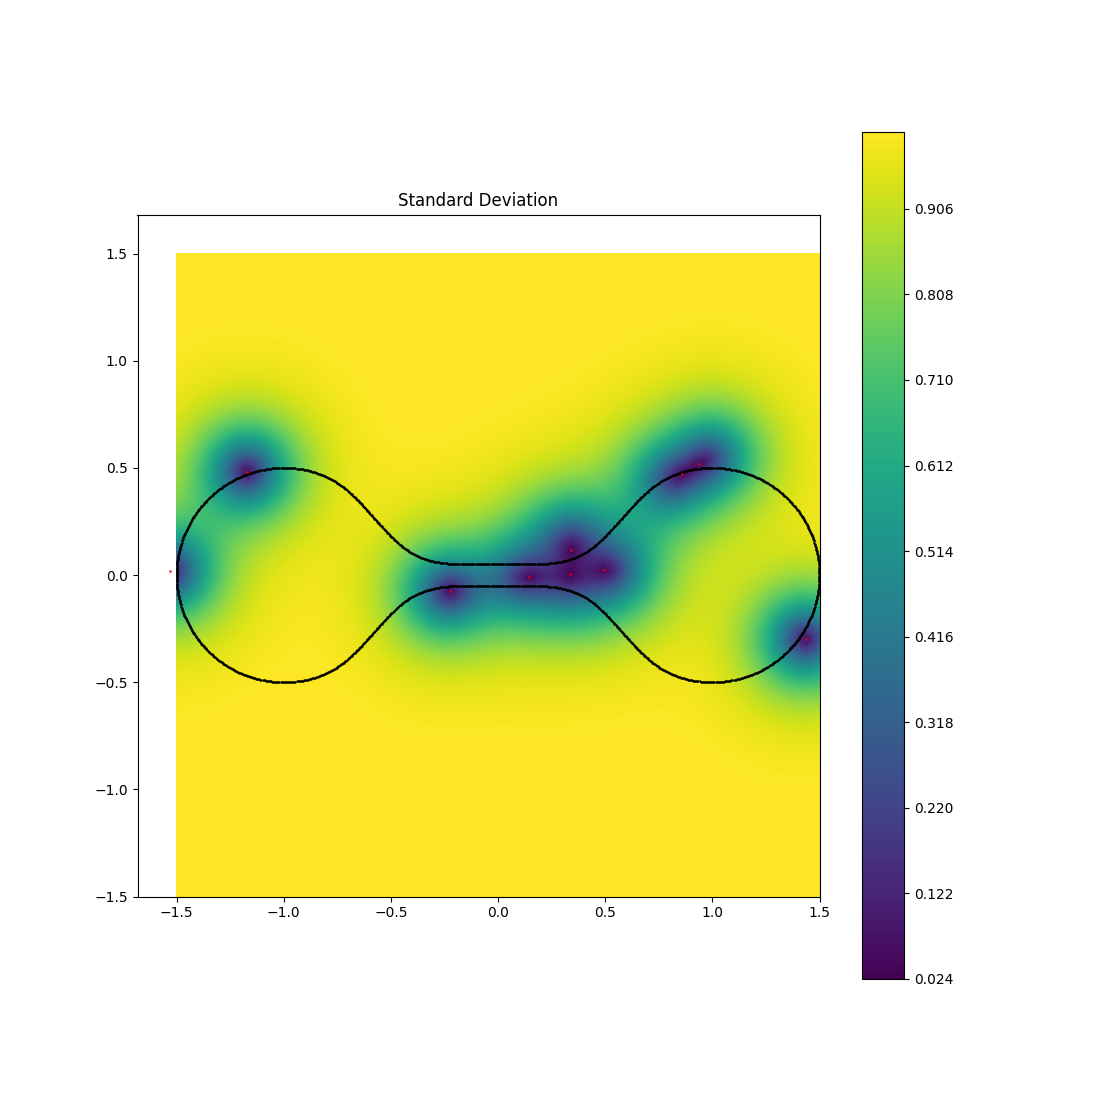

In [18]:
with torch.no_grad():
    posterior_std_ambient = preds_ambient.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Standard Deviation')